In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = 999
sns.set_style('whitegrid')

# https://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_csv('PHL_Building_Dataset_ML_Classification.csv')
df = df.drop(columns=['Unnamed: 0', 'basements_bin'])
df

,basements,building_code_description,central_air,depth,exterior_condition,fireplaces,frontage,garage_type,interior_condition,location,market_value,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,parcel_shape,street_designation,topography,total_area,total_livable_area,type_heater,view_type,year_built,zoning,building_description,section,segment
0,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,29.17,A,4.0,220 WHARTON ST,257500.0,2.0,3.0,6.0,2.0,E,ST,6,2625.30,1266.0,H,I,1960.0,1,MASONRY,South,2
1,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.03,A,4.0,222 WHARTON ST,249400.0,2.0,3.0,6.0,2.0,E,ST,6,1622.70,1266.0,A,I,1960.0,1,MASONRY,South,2
2,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.05,A,4.0,224 WHARTON ST,249500.0,2.0,3.0,6.0,2.0,E,ST,6,1624.50,1266.0,A,I,1960.0,1,MASONRY,South,2
3,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.08,A,4.0,226 WHARTON ST,249500.0,2.0,3.0,6.0,2.0,E,ST,6,1627.20,1266.0,H,I,1960.0,1,MASONRY,South,2
4,0,ROW B/GAR 2 STY MASONRY,Y,90.00,4.0,0.0,18.71,A,4.0,228 WHARTON ST,253800.0,2.0,3.0,6.0,2.0,E,ST,6,1683.90,1310.0,H,I,1960.0,1,MASONRY,South,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77615,0,RES CONDO 4 STY MAS+OTH,Y,59.00,2.0,0.0,25.60,0,2.0,2553 MONTROSE ST,235600.0,0.0,2.0,4.0,4.0,E,ST,6,1510.40,752.0,A,I,2019.0,1,MASONRY+OTHER,South,2
77616,0,RES CONDO 4 STY MAS+OTH,Y,59.00,2.0,0.0,25.60,0,2.0,2553 MONTROSE ST,232800.0,0.0,1.0,3.0,4.0,E,ST,6,1510.40,684.0,A,I,2019.0,1,MASONRY+OTHER,South,2
77617,0,RES CONDO 4 STY MAS+OTH,Y,59.00,2.0,0.0,25.60,0,2.0,2553 MONTROSE ST,256500.0,0.0,2.0,4.0,4.0,E,ST,6,1510.40,948.0,A,I,2019.0,1,MASONRY+OTHER,South,2
77618,0,RES CONDO 2 STY FRAME,Y,55.27,2.0,0.0,30.31,0,2.0,1220 N ETTING ST,218500.0,0.0,3.0,5.0,2.0,E,ST,6,1675.38,800.0,A,I,2019.0,1,FRAME,North,2


In [5]:
# Rename Segment
df['segment'] = df['segment'].replace({1:'Bottom', 2:'Lower Middle', 3:'Middle', 4:'Upper Middle', 5:'Top'})

# Splitting Data

In [6]:
X = df.drop(columns=['building_code_description', 'segment'])
y = df['segment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

# Evaluation Matrix

In [8]:
# Evaluation Matrix Classification
def Eva_Matrix1(Model, X_train, y_train, X_test, y_test, Name):
    y_pred_train = Model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    rec_train = recall_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    y_pred_test = Model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    f1_test = f1_score(y_train, y_pred_train)
    data = {
        f"Training {Name}" : [acc_train, rec_train, prec_train, f1_train],
        f"Test {Name}" : [acc_test, rec_test, prec_test, f1_test]
    }
    df = pd.DataFrame(data=data, index=['Accuracy', 'Recall', 'Precision', 'F1'])
    return df

# Pipeline

In [9]:
# Based on EDA there are several columns that we choose for Machine Learning Modelling
num_columns = ['fireplaces', 'market_value', 'number_of_rooms', 'total_area', 
               'total_livable_area']

cat_columns = ['basements', 'central_air', 'exterior_condition', 'garage_type',
               'interior_condition', 'parcel_shape', 'topography',
               'type_heater', 'view_type', 'building_description']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', RobustScaler()),
    #('poly', PolynomialFeatures(degree=3, include_bias=False)),
    #('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categoric', categoric_pipeline, cat_columns)
])

pipeSVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(max_iter=400, probability=True))
])

pipeLR = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression())
])

pipeKNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])
               
pipeDT = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier())
])
            
pipeRF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

# Base Model (KNN)

In [10]:
pipeKNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [11]:
y_KNN_train = pipeKNN.predict(X_train)

In [12]:
y_KNN_test = pipeKNN.predict(X_test)

In [13]:
accuracy_train_KNN_base = accuracy_score(y_train, y_KNN_train)
accuracy_train_KNN_base

0.9997906467405308

In [14]:
accuracy_test_KNN_base = accuracy_score(y_test, y_KNN_test)
accuracy_test_KNN_base

0.9994202525122391

In [15]:
f1score_train_KNN_base = f1_score(y_train, y_KNN_train, average='weighted')
f1score_train_KNN_base

0.9997906436550099

In [16]:
f1score_test_KNN_base = f1_score(y_test, y_KNN_test, average='weighted')
f1score_test_KNN_base

0.9994200565423182

In [17]:
print(classification_report(y_test, y_KNN_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      1.00      1.00      1049
         Top       1.00      0.98      0.99        47
Upper Middle       0.99      1.00      1.00       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



# Base Model Logistic Regression

In [18]:
pipeLR.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [19]:
y_LR_train = pipeLR.predict(X_train)

In [20]:
y_LR_test = pipeLR.predict(X_test)

In [21]:
accuracy_train_LR_base = accuracy_score(y_train, y_LR_train)
accuracy_train_LR_base

0.7727228807008503

In [22]:
accuracy_test_LR_base = accuracy_score(y_test, y_LR_test)
accuracy_test_LR_base

0.7737052306106673

In [23]:
f1score_train_LR_base = f1_score(y_train, y_LR_train, average='weighted')
f1score_train_LR_base

0.756835408081782

In [24]:
f1score_test_LR_base = f1_score(y_test, y_LR_test, average='weighted')
f1score_test_LR_base

0.7589212672528929

In [25]:
print(classification_report(y_test, y_LR_test))

              precision    recall  f1-score   support

      Bottom       0.86      0.85      0.85      8570
Lower Middle       0.68      0.80      0.73      5679
      Middle       0.64      0.15      0.25      1049
         Top       0.06      0.02      0.03        47
Upper Middle       0.28      0.11      0.15       179

    accuracy                           0.77     15524
   macro avg       0.50      0.39      0.40     15524
weighted avg       0.77      0.77      0.76     15524



# Base Model SVM

In [26]:
pipeSVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [27]:
y_SVM_train = pipeSVM.predict(X_train)

In [28]:
y_SVM_test = pipeSVM.predict(X_test)

In [29]:
accuracy_train_SVM_base = accuracy_score(y_train, y_SVM_train)
accuracy_train_SVM_base

0.9990820664777119

In [30]:
accuracy_test_SVM_base = accuracy_score(y_test, y_SVM_test)
accuracy_test_SVM_base

0.9990981705745942

In [31]:
f1score_train_SVM_base = f1_score(y_train, y_SVM_train, average='weighted')
f1score_train_SVM_base

0.9990803883249478

In [32]:
f1score_test_SVM_base = f1_score(y_test, y_SVM_test, average='weighted')
f1score_test_SVM_base

0.999097173248425

In [33]:
print(classification_report(y_test, y_SVM_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      0.99      0.99      1049
         Top       0.98      1.00      0.99        47
Upper Middle       1.00      0.99      0.99       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



# Base Model (DecisionTreeClassifier)

In [34]:
pipeDT.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [35]:
y_DT_train = pipeDT.predict(X_train)

In [36]:
y_DT_test = pipeDT.predict(X_test)

In [37]:
accuracy_train_DT_base = accuracy_score(y_train, y_DT_train)
accuracy_train_DT_base

1.0

In [38]:
accuracy_test_DT_base = accuracy_score(y_test, y_DT_test)
accuracy_test_DT_base

0.999935583612471

In [39]:
f1score_train_DT_base = f1_score(y_train, y_DT_train, average='weighted')
f1score_train_DT_base

1.0

In [40]:
f1score_test_DT_base = f1_score(y_test, y_DT_test, average='weighted')
f1score_test_DT_base

0.9999355826555087

In [41]:
print(classification_report(y_test, y_DT_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      1.00      1.00      1049
         Top       1.00      1.00      1.00        47
Upper Middle       1.00      1.00      1.00       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



# Base Model (Random Forest Classifier)

In [42]:
pipeRF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [43]:
y_RF_train = pipeRF.predict(X_train)

In [44]:
y_RF_test = pipeRF.predict(X_test)

In [45]:
accuracy_train_RF_base = accuracy_score(y_train, y_RF_train)
accuracy_train_RF_base

1.0

In [46]:
accuracy_test_RF_base = accuracy_score(y_test, y_RF_test)
accuracy_test_RF_base

0.9973589281113115

In [47]:
f1score_train_RF_base = f1_score(y_train, y_RF_train, average='weighted')
f1score_train_RF_base

1.0

In [48]:
f1score_test_RF_base = f1_score(y_test, y_RF_test, average='weighted')
f1score_test_RF_base

0.9972385421349833

In [49]:
print(classification_report(y_test, y_RF_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       0.98      1.00      0.99      1049
         Top       0.97      0.66      0.78        47
Upper Middle       0.91      0.88      0.89       179

    accuracy                           1.00     15524
   macro avg       0.97      0.91      0.93     15524
weighted avg       1.00      1.00      1.00     15524



# =================================================

# Hyper Parameter Tuning

## Logistic Regression

In [50]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_LR = {
    "algo__C" : np.logspace(-3, 3, 7),
    "algo__penalty" : ['l1', 'l2', 'elasticnet'],
    "algo__fit_intercept" : [True,False]
}

GS_LR = GridSearchCV(pipeLR, param_LR, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_LR.fit(X_train, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  4.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [51]:
GS_LR.best_params_

{'algo__C': 0.001, 'algo__fit_intercept': True, 'algo__penalty': 'l2'}

In [52]:
LR_Tuned = GS_LR.best_estimator_

In [53]:
y_LR_Tuned_train = LR_Tuned.predict(X_train)

In [54]:
y_LR_Tuned_test = LR_Tuned.predict(X_test)

In [55]:
accuracy_train_LR_HyperTune = accuracy_score(y_train, y_LR_Tuned_train)
accuracy_train_LR_HyperTune

0.7653633084256635

In [56]:
accuracy_test_LR_HyperTune = accuracy_score(y_test, y_LR_Tuned_test)
accuracy_test_LR_HyperTune

0.770484411234218

In [57]:
f1score_train_LR_HyperTune = f1_score(y_train, y_LR_Tuned_train, average='weighted')
f1score_train_LR_HyperTune

0.7503927190068842

In [58]:
f1score_test_LR_HyperTune = f1_score(y_test, y_LR_Tuned_test, average='weighted')
f1score_test_LR_HyperTune

0.7560580318800948

In [59]:
print(classification_report(y_test, y_LR_Tuned_test))

              precision    recall  f1-score   support

      Bottom       0.86      0.85      0.85      8570
Lower Middle       0.68      0.80      0.73      5679
      Middle       0.48      0.16      0.25      1049
         Top       0.06      0.02      0.03        47
Upper Middle       0.15      0.02      0.04       179

    accuracy                           0.77     15524
   macro avg       0.45      0.37      0.38     15524
weighted avg       0.76      0.77      0.76     15524



# DecisionTreeClassifier

In [60]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_DT = {
   'algo__max_depth': [None, 5, 10, 15], 
   'algo__min_samples_leaf' : np.arange(1, 17, 5), 
   'algo__max_features' : [0.3, 0.5, 0.7, 0.8]
}

GS_DT = GridSearchCV(pipeDT, param_DT, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_DT.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  4.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [61]:
GS_DT.best_params_

{'algo__max_depth': None,
 'algo__max_features': 0.8,
 'algo__min_samples_leaf': 11}

In [62]:
DT_Tuned = GS_DT.best_estimator_

In [63]:
y_DT_Tuned_train = DT_Tuned.predict(X_train)

In [64]:
y_DT_Tuned_test = DT_Tuned.predict(X_test)

In [65]:
accuracy_train_DT_HyperTune = accuracy_score(y_train, y_DT_Tuned_train)
accuracy_train_DT_HyperTune

0.9999677918062355

In [66]:
accuracy_test_DT_HyperTune = accuracy_score(y_test, y_DT_Tuned_test)
accuracy_test_DT_HyperTune

0.9998711672249421

In [67]:
f1score_train_DT_HyperTune = f1_score(y_train, y_DT_Tuned_train, average='weighted')
f1score_train_DT_HyperTune

0.9999677949361512

In [68]:
f1score_test_DT_HyperTune = f1_score(y_test, y_DT_Tuned_test, average='weighted')
f1score_test_DT_HyperTune

0.999871173103591

In [69]:
print(classification_report(y_test, y_DT_Tuned_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      1.00      1.00      1049
         Top       1.00      1.00      1.00        47
Upper Middle       1.00      1.00      1.00       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



# RandomForestClassifier

In [70]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_RF = {
    "algo__n_estimators" : np.arange(100, 301, 100),
    "algo__max_depth" : [None, 5],
    "algo__min_samples_leaf" : np.arange(1, 12, 5),
    "algo__max_features" : [0.3, 0.5]
}

GS_RF = GridSearchCV(pipeRF, param_RF, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_RF.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 16.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [71]:
GS_RF.best_params_

{'algo__max_depth': None,
 'algo__max_features': 0.5,
 'algo__min_samples_leaf': 1,
 'algo__n_estimators': 200}

In [72]:
RF_Tuned = GS_RF.best_estimator_

In [73]:
y_RF_Tuned_train = RF_Tuned.predict(X_train)

In [74]:
y_RF_Tuned_test = RF_Tuned.predict(X_test)

In [75]:
accuracy_train_RF_HyperTune = accuracy_score(y_train, y_RF_Tuned_train)
accuracy_train_RF_HyperTune

1.0

In [76]:
accuracy_test_RF_HyperTune = accuracy_score(y_test, y_RF_Tuned_test)
accuracy_test_RF_HyperTune

0.9998711672249421

In [77]:
f1score_train_RF_HyperTune = f1_score(y_train, y_RF_Tuned_train, average='weighted')
f1score_train_RF_HyperTune

1.0

In [78]:
f1score_test_RF_HyperTune = f1_score(y_test, y_RF_Tuned_test, average='weighted')
f1score_test_RF_HyperTune

0.999871173103591

In [79]:
print(classification_report(y_test, y_RF_Tuned_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      1.00      1.00      1049
         Top       1.00      1.00      1.00        47
Upper Middle       1.00      1.00      1.00       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



# KNN

In [80]:
skf = StratifiedKFold(n_splits=3, random_state=42)

param_KNN = {
    "algo__n_neighbors" : np.arange(1, 15, 2),
    "algo__p" : [1, 2],
    "algo__weights" : ['uniform', 'distance']
}

GS_KNN = GridSearchCV(pipeKNN, param_KNN, cv = skf, n_jobs = -1, verbose = 1, scoring='balanced_accuracy')
GS_KNN.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed: 65.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['fireplaces',
                                                                          'market_value',
                                                                          'number_of_rooms',
                                                                          'total_area',
                                                                          'total_livable_area']),
                                                                        ('categoric',
                                     

In [81]:
GS_KNN.best_params_

{'algo__n_neighbors': 7, 'algo__p': 1, 'algo__weights': 'distance'}

In [82]:
KNN_Tuned = GS_KNN.best_estimator_

In [83]:
y_KNN_Tuned_train = KNN_Tuned.predict(X_train)

In [84]:
y_KNN_Tuned_test = KNN_Tuned.predict(X_test)

In [85]:
accuracy_train_KNN_HyperTune = accuracy_score(y_train, y_KNN_Tuned_train)
accuracy_train_KNN_HyperTune

1.0

In [86]:
accuracy_test_KNN_HyperTune = accuracy_score(y_test, y_KNN_Tuned_test)
accuracy_test_KNN_HyperTune

0.999742334449884

In [87]:
f1score_train_KNN_HyperTune = f1_score(y_train, y_KNN_Tuned_train, average='weighted')
f1score_train_KNN_HyperTune

1.0

In [88]:
f1score_test_KNN_HyperTune = f1_score(y_test, y_KNN_Tuned_test, average='weighted')
f1score_test_KNN_HyperTune

0.9997420846782473

In [89]:
print(classification_report(y_test, y_KNN_Tuned_test))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      1.00      1.00      1049
         Top       1.00      0.98      0.99        47
Upper Middle       0.99      1.00      1.00       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



# =================================================

# Fine Tuning

## DecisionTreeClassifier

In [90]:
pipeDT_Tuning = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier(max_depth = 4, max_features = 0.5, min_samples_leaf = 4, min_samples_split = 2, random_state=42))
])

In [91]:
pipeDT_Tuning.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [92]:
y_train_DT_Fine_Tuned = pipeDT_Tuning.predict(X_train)

In [93]:
y_test_DT_Fine_Tuned = pipeDT_Tuning.predict(X_test)

In [94]:
accuracy_train_DT_FineTune = accuracy_score(y_train, y_train_DT_Fine_Tuned)
accuracy_train_DT_FineTune

0.9570664777119299

In [95]:
accuracy_test_DT_FineTune = accuracy_score(y_test, y_test_DT_Fine_Tuned)
accuracy_test_DT_FineTune

0.9567121875805205

In [96]:
f1score_train_DT_FineTune = f1_score(y_train, y_train_DT_Fine_Tuned, average='weighted')
f1score_train_DT_FineTune

0.9531036262798046

In [97]:
f1score_test_DT_FineTune = f1_score(y_test, y_test_DT_Fine_Tuned, average='weighted')
f1score_test_DT_FineTune

0.9523986538739759

In [98]:
print(classification_report(y_test, y_test_DT_Fine_Tuned))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       0.92      0.98      0.95      5679
      Middle       0.80      0.56      0.66      1049
         Top       0.00      0.00      0.00        47
Upper Middle       0.78      0.81      0.79       179

    accuracy                           0.96     15524
   macro avg       0.70      0.67      0.68     15524
weighted avg       0.95      0.96      0.95     15524



## RandomForestClassifier

In [99]:
pipeRF_tuning = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(n_estimators = 100, max_depth= None, min_samples_leaf= 2, max_features= 0.3))
])

In [100]:
pipeRF_tuning.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [101]:
y_train_RF_Fine_Tuned = pipeRF_tuning.predict(X_train)

In [102]:
y_test_RF_Fine_Tuned = pipeRF_tuning.predict(X_test)

In [103]:
accuracy_train_RF_FineTune = accuracy_score(y_train, y_train_RF_Fine_Tuned)
accuracy_train_RF_FineTune

0.9999838959031178

In [104]:
accuracy_test_RF_FineTune = accuracy_score(y_test, y_test_RF_Fine_Tuned)
accuracy_test_RF_FineTune

0.999742334449884

In [105]:
f1score_train_RF_FineTune = f1_score(y_train, y_train_RF_Fine_Tuned, average='weighted')
f1score_train_RF_FineTune

0.9999838753908227

In [106]:
f1score_test_RF_FineTune = f1_score(y_test, y_test_RF_Fine_Tuned, average='weighted')
f1score_test_RF_FineTune

0.9997420400082673

In [107]:
print(classification_report(y_test, y_test_DT_Fine_Tuned))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       0.92      0.98      0.95      5679
      Middle       0.80      0.56      0.66      1049
         Top       0.00      0.00      0.00        47
Upper Middle       0.78      0.81      0.79       179

    accuracy                           0.96     15524
   macro avg       0.70      0.67      0.68     15524
weighted avg       0.95      0.96      0.95     15524



# =================================================

# Random Over Sampling

In [108]:
from sklearn.utils import resample

In [109]:
df_train = pd.concat([X_train, y_train], axis=1)

In [110]:
df_train['segment'].value_counts()

Bottom          34281
Lower Middle    22716
Middle           4194
Upper Middle      717
Top               188
Name: segment, dtype: int64

In [111]:
top = df_train[df_train['segment'] == 'Top'] ## Minority Class
upper_middle = df_train[df_train['segment'] == 'Upper Middle']
middle = df_train[df_train['segment'] == 'Middle']

In [112]:
lower_middle = df_train[df_train['segment'] == 'Lower Middle'] ## Majority Class


In [113]:
bottom = df_train[df_train['segment'] == 'Bottom'] ## Majority Class


In [114]:
top_oversample = resample(top, ## Minority Class
                           replace=True,
                           n_samples=len(bottom), ## Majority Class
                           random_state = 42)
upper_middle_oversample = resample(upper_middle, ## Minority Class
                           replace=True,
                           n_samples=len(bottom), ## Majority Class
                           random_state = 42)
middle_oversample = resample(middle, ## Kelas Minority
                           replace=True,
                           n_samples=len(bottom), ## Majority Class
                           random_state = 42)

In [115]:
df_OverSample = pd.concat([bottom, lower_middle, top_oversample, upper_middle_oversample, middle_oversample])

In [116]:
df_sample = df_OverSample[['basements', 'central_air', 'exterior_condition', 'fireplaces', 'garage_type', 'interior_condition', 'market_value', 'number_of_rooms', 'parcel_shape', 'topography', 'total_area', 'total_livable_area', 'type_heater', 'view_type', 'building_description', 'segment']]

In [117]:
df_sample

,basements,central_air,exterior_condition,fireplaces,garage_type,interior_condition,market_value,number_of_rooms,parcel_shape,topography,total_area,total_livable_area,type_heater,view_type,building_description,segment
51355,F,N,4.0,0.0,A,4.0,111800.0,6.0,E,6,1440.00,1120.0,0,A,MASONRY,Bottom
60116,H,N,4.0,0.0,A,4.0,137300.0,7.0,E,6,1440.00,1600.0,H,I,MASONRY,Bottom
43974,F,N,4.0,0.0,A,4.0,106400.0,6.0,E,6,1536.00,1338.0,0,I,MASONRY,Bottom
61434,J,N,4.0,0.0,0,4.0,77000.0,6.0,E,6,2016.00,1255.0,H,I,MASONRY,Bottom
65818,D,N,4.0,0.0,A,4.0,164200.0,6.0,E,6,1600.00,1432.0,0,I,MASONRY,Bottom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60414,0,Y,3.0,1.0,A,4.0,346000.0,8.0,E,6,5324.00,2092.0,0,I,FRAME,Middle
19297,C,N,4.0,0.0,0,3.0,314400.0,8.0,E,6,3987.63,2736.0,B,I,MASONRY,Middle
1015,D,N,4.0,0.0,A,4.0,376200.0,6.0,E,6,1623.60,1260.0,0,I,MASONRY,Middle
16059,E,N,3.0,1.0,B,3.0,338300.0,6.0,E,6,6095.00,1622.0,B,C,MASONRY,Middle


In [118]:
X_train_OS = df_sample.drop(columns='segment')
y_train_OS = df_sample['segment']

## LogisticRegression Random Over Sampling (Base Model)

In [119]:
pipeLR.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [120]:
y_LR_trainOS = pipeLR.predict(X_train)

In [121]:
y_LR_testOS = pipeLR.predict(X_test)

In [122]:
accuracy_train_LR_base_OS = accuracy_score(y_train, y_LR_trainOS)
accuracy_train_LR_base_OS

0.4074336511208451

In [123]:
accuracy_test_LR_base_OS = accuracy_score(y_test, y_LR_testOS)
accuracy_test_LR_base_OS

0.4123292965730482

In [124]:
f1score_train_LR_base_OS = f1_score(y_train, y_LR_trainOS, average='weighted')
f1score_train_LR_base_OS

0.43635693496446504

In [125]:
f1score_test_LR_base_OS = f1_score(y_test, y_LR_testOS, average='weighted')
f1score_test_LR_base_OS

0.43957426757359813

In [126]:
print(classification_report(y_test, y_LR_testOS))

              precision    recall  f1-score   support

      Bottom       0.92      0.68      0.78      8570
Lower Middle       0.00      0.00      0.00      5679
      Middle       0.07      0.48      0.11      1049
         Top       0.05      0.83      0.09        47
Upper Middle       0.05      0.20      0.08       179

    accuracy                           0.41     15524
   macro avg       0.22      0.44      0.21     15524
weighted avg       0.51      0.41      0.44     15524



## KNN Random Over Sampling (Base Model)

In [127]:
pipeKNN.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [128]:
y_KNN_trainOS = pipeKNN.predict(X_train)

In [129]:
y_KNN_testOS = pipeKNN.predict(X_test)

In [130]:
accuracy_train_KNN_base_OS = accuracy_score(y_train, y_KNN_trainOS)
accuracy_train_KNN_base_OS

0.9997584385467663

In [131]:
accuracy_test_KNN_base_OS = accuracy_score(y_test, y_KNN_testOS)
accuracy_test_KNN_base_OS

0.9994202525122391

In [132]:
f1score_train_KNN_base_OS = f1_score(y_train, y_KNN_trainOS, average='weighted')
f1score_train_KNN_base_OS

0.9997584915111429

In [133]:
f1score_test_KNN_base_OS = f1_score(y_test, y_KNN_testOS, average='weighted')
f1score_test_KNN_base_OS

0.9994202109932562

In [134]:
print(classification_report(y_test, y_KNN_testOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      1.00      1.00      1049
         Top       1.00      0.98      0.99        47
Upper Middle       0.99      1.00      1.00       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



## DecisionTreeClassifier Random Over Sample (Base Model)

In [135]:
pipeDT.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [136]:
y_DT_trainOS = pipeDT.predict(X_train)

In [137]:
y_DT_testOS = pipeDT.predict(X_test)

In [138]:
accuracy_train_DT_base_OS = accuracy_score(y_train, y_DT_trainOS)
accuracy_train_DT_base_OS

1.0

In [139]:
accuracy_test_DT_base_OS = accuracy_score(y_test, y_DT_testOS)
accuracy_test_DT_base_OS

0.999935583612471

In [140]:
f1score_train_DT_base_OS = f1_score(y_train, y_DT_trainOS, average='weighted')
f1score_train_DT_base_OS

1.0

In [141]:
f1score_test_DT_base_OS = f1_score(y_test, y_DT_testOS, average='weighted')
f1score_test_DT_base_OS

0.9999355826555087

In [142]:
print(classification_report(y_test, y_DT_testOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       1.00      1.00      1.00      1049
         Top       1.00      1.00      1.00        47
Upper Middle       1.00      1.00      1.00       179

    accuracy                           1.00     15524
   macro avg       1.00      1.00      1.00     15524
weighted avg       1.00      1.00      1.00     15524



## DecisionTreeClassifier Random Over Sample (Fine Tuning)

In [143]:
pipeDT_Tuning_OS = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier(max_depth = 5, max_features = 0.4, min_samples_leaf = 2, min_samples_split = 2, random_state=42))
])

In [144]:
pipeDT_Tuning_OS.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [145]:
y_train_DT_Fine_TunedOS = pipeDT_Tuning_OS.predict(X_train)

In [146]:
y_test_DT_Fine_TunedOS = pipeDT_Tuning_OS.predict(X_test)

In [147]:
accuracy_train_DT_FineTune_OS = accuracy_score(y_train, y_train_DT_Fine_TunedOS)
accuracy_train_DT_FineTune_OS

0.7852035557845916

In [148]:
accuracy_test_DT_FineTune_OS = accuracy_score(y_test, y_test_DT_Fine_TunedOS)
accuracy_test_DT_FineTune_OS

0.7823370265395516

In [149]:
f1score_train_DT_FineTune_OS = f1_score(y_train, y_train_DT_Fine_TunedOS, average='weighted')
f1score_train_DT_FineTune_OS

0.800293824131444

In [150]:
f1score_test_DT_FineTune_OS = f1_score(y_test, y_test_DT_Fine_TunedOS, average='weighted')
f1score_test_DT_FineTune_OS

0.7987300345298077

In [151]:
print(classification_report(y_test, y_test_DT_Fine_TunedOS))

              precision    recall  f1-score   support

      Bottom       0.89      0.87      0.88      8570
Lower Middle       0.86      0.64      0.74      5679
      Middle       0.30      0.76      0.43      1049
         Top       0.75      0.87      0.80        47
Upper Middle       0.94      0.93      0.93       179

    accuracy                           0.78     15524
   macro avg       0.75      0.82      0.76     15524
weighted avg       0.84      0.78      0.80     15524



## RandomForestClassifier Random Over Sample (Fine Tuning)

In [152]:
pipeRF_Tuning_OS = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(max_depth = 6, max_features = 0.15, min_samples_leaf = 10, min_samples_split = 5, random_state=42))
])

In [153]:
pipeRF_Tuning_OS.fit(X_train_OS, y_train_OS)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [154]:
y_train_RF_Fine_TunedOS = pipeRF_Tuning_OS.predict(X_train)

In [155]:
y_test_RF_Fine_TunedOS = pipeRF_Tuning_OS.predict(X_test)

In [156]:
accuracy_train_RF_FineTune_OS = accuracy_score(y_train, y_train_RF_Fine_TunedOS)
accuracy_train_RF_FineTune_OS

0.9577106415872197

In [157]:
accuracy_test_RF_FineTune_OS = accuracy_score(y_test, y_test_RF_Fine_TunedOS)
accuracy_test_RF_FineTune_OS

0.9603195052821438

In [158]:
f1score_train_RF_FineTune_OS = f1_score(y_train, y_train_RF_Fine_TunedOS, average='weighted')
f1score_train_RF_FineTune_OS

0.9611502243673172

In [159]:
f1score_test_RF_FineTune_OS = f1_score(y_test, y_test_RF_Fine_TunedOS, average='weighted')
f1score_test_RF_FineTune_OS

0.9633338570402661

In [160]:
print(classification_report(y_train, y_train_RF_Fine_TunedOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00     34281
Lower Middle       0.99      0.90      0.94     22716
      Middle       0.62      0.95      0.75      4194
         Top       1.00      0.99      0.99       188
Upper Middle       0.88      0.99      0.93       717

    accuracy                           0.96     62096
   macro avg       0.90      0.97      0.92     62096
weighted avg       0.97      0.96      0.96     62096



In [161]:
print(classification_report(y_test, y_test_RF_Fine_TunedOS))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       0.99      0.91      0.95      5679
      Middle       0.64      0.94      0.76      1049
         Top       0.98      0.98      0.98        47
Upper Middle       0.86      0.97      0.91       179

    accuracy                           0.96     15524
   macro avg       0.89      0.96      0.92     15524
weighted avg       0.97      0.96      0.96     15524



# =================================================

# Conclusion Model

In [162]:
p1 = {'Training KNN Base' : [accuracy_train_KNN_base, f1score_train_KNN_base],
'Testing KNN Base' : [accuracy_test_KNN_base, f1score_test_KNN_base],

'Training LR Base' : [accuracy_train_LR_base, f1score_train_LR_base],
'Testing LR Base' : [accuracy_test_LR_base, f1score_test_LR_base],

'Training SVM Base' : [accuracy_train_SVM_base, f1score_train_SVM_base],
'Testing SVM Base' : [accuracy_test_SVM_base, f1score_test_SVM_base],

'Training DT Base' : [accuracy_train_DT_base, f1score_train_DT_base],
'Testing DT Base' : [accuracy_test_DT_base, f1score_test_DT_base],

'Training RF Base' : [accuracy_train_RF_base, f1score_train_RF_base],
'Testing RF Base' : [accuracy_test_RF_base, f1score_test_RF_base]}

p2 = {'Training LR HyperTune' : [accuracy_train_LR_HyperTune, f1score_train_LR_HyperTune],
'Testing LR HyperTune' : [accuracy_test_LR_HyperTune, f1score_test_LR_HyperTune],

'Training DT HyperTune' : [accuracy_train_DT_HyperTune, f1score_train_DT_HyperTune],
'Testing DT HyperTune' : [accuracy_test_DT_HyperTune, f1score_test_DT_HyperTune],

'Training RF HyperTune' : [accuracy_train_RF_HyperTune, f1score_train_RF_HyperTune],
'Testing RF HyperTune' : [accuracy_test_RF_HyperTune, f1score_test_RF_HyperTune],

'Training KNN HyperTune' : [accuracy_train_KNN_HyperTune, f1score_train_KNN_HyperTune],
'Testing KNN HyperTune' : [accuracy_test_KNN_HyperTune, f1score_test_KNN_HyperTune]}

p3 = {'Training DT FineTune' : [accuracy_train_DT_FineTune, f1score_train_DT_FineTune],
'Testing DT FineTune' : [accuracy_test_DT_FineTune, f1score_test_DT_FineTune],

'Training RF FineTune' : [accuracy_train_RF_FineTune, f1score_train_RF_FineTune],
'Testing RF FineTune' : [accuracy_test_RF_FineTune, f1score_test_RF_FineTune]}

p4 = {'Training LR Base OverSampling' : [accuracy_train_LR_base_OS, f1score_train_LR_base_OS],
'Testing LR Base OverSampling' : [accuracy_test_LR_base_OS, f1score_test_LR_base_OS],

'Training KNN Base OverSampling' : [accuracy_train_KNN_base_OS, f1score_train_KNN_base_OS],
'Testing KNN Base OverSampling' : [accuracy_test_KNN_base_OS, f1score_test_KNN_base_OS],

'Training DT Base OverSampling' : [accuracy_train_DT_base_OS, f1score_train_DT_base_OS],
'Testing DT Base OverSampling' : [accuracy_test_DT_base_OS, f1score_test_DT_base_OS]}

p5 = {'Training DT FineTune OverSampling' : [accuracy_train_DT_FineTune_OS, f1score_train_DT_FineTune_OS],
'Testing DT FineTune OverSampling' : [accuracy_test_DT_FineTune_OS, f1score_test_DT_FineTune_OS],

'Training RF FineTune OverSampling' : [accuracy_train_RF_FineTune_OS, f1score_train_RF_FineTune_OS],
'Testing RF FineTune OverSampling' : [accuracy_test_RF_FineTune_OS, f1score_test_RF_FineTune_OS]}

## Base Model

In [163]:
df_base_model = pd.DataFrame(data=p1, index=['Accuracy', 'F1-Score'])
df_base_model.T

,Accuracy,F1-Score
Training KNN Base,0.999791,0.999791
Testing KNN Base,0.999420,0.999420
Training LR Base,0.772723,0.756835
Testing LR Base,0.773705,0.758921
Training SVM Base,0.999082,0.999080
Testing SVM Base,0.999098,0.999097
Training DT Base,1.000000,1.000000
Testing DT Base,0.999936,0.999936
Training RF Base,1.000000,1.000000
Testing RF Base,0.997359,0.997239


## Hyper Parameter Tuning

In [164]:
df_hyper_parameter_tuning = pd.DataFrame(data=p2, index=['Accuracy', 'F1-Score'])
df_hyper_parameter_tuning.T

,Accuracy,F1-Score
Training LR HyperTune,0.765363,0.750393
Testing LR HyperTune,0.770484,0.756058
Training DT HyperTune,0.999968,0.999968
Testing DT HyperTune,0.999871,0.999871
Training RF HyperTune,1.000000,1.000000
Testing RF HyperTune,0.999871,0.999871
Training KNN HyperTune,1.000000,1.000000
Testing KNN HyperTune,0.999742,0.999742


## Fine Tuning

In [165]:
df_fine_tuning = pd.DataFrame(data=p3, index=['Accuracy', 'F1-Score'])
df_fine_tuning.T

,Accuracy,F1-Score
Training DT FineTune,0.957066,0.953104
Testing DT FineTune,0.956712,0.952399
Training RF FineTune,0.999984,0.999984
Testing RF FineTune,0.999742,0.999742


## Base Model Over Sampling

In [166]:
df_base_model_os = pd.DataFrame(data=p4, index=['Accuracy', 'F1-Score'])
df_base_model_os.T

,Accuracy,F1-Score
Training LR Base OverSampling,0.407434,0.436357
Testing LR Base OverSampling,0.412329,0.439574
Training KNN Base OverSampling,0.999758,0.999758
Testing KNN Base OverSampling,0.999420,0.999420
Training DT Base OverSampling,1.000000,1.000000
Testing DT Base OverSampling,0.999936,0.999936


## Fine Tuning Over Sampling

In [167]:
df_fine_tuning_os = pd.DataFrame(data=p5, index=['Accuracy', 'F1-Score'])
df_fine_tuning_os.T

,Accuracy,F1-Score
Training DT FineTune OverSampling,0.785204,0.800294
Testing DT FineTune OverSampling,0.782337,0.798730
Training RF FineTune OverSampling,0.957711,0.961150
Testing RF FineTune OverSampling,0.960320,0.963334


# =================================================

# Conclusion

Based of these 4 base model we created above, several models with high marks (Strong Learner) are KNN, SVM, DecisionTreeClassifier, RandomForestClassifier. LogisticRegression is having 0.77 Accuracy Score in Train Data and 0.77 on Test Data. After we did Hyper Parameter Tuning, the result is quite similar with the base model. So we decided to do Fine Tuning on the DecisionTreeClassifier Model and achieved Good Learner result with Acccuracy Score 0.96 for Test Data, 0.95 weighted F1 Score and 0.68 macro average. But, Imbalance Class can be found in this Multiclass Target Data, therefore we try to use Random Over Sampling for Minority Class. After we used Random Over Sampling for KNN base model and DT, we get too high (Strong Learner) score with below average Logistic Regression result.  After some Fine Tuning on Over Sampled Data, we achieved better result of 0.96 for Accuracy for Train Data and Test Data, 0.96 weighted score for F1 and 0.92 macro average. In the end, we decided to use Fine Tuning RandomForestClassifier Model with Random Over Sampling to get a balanced data and better macro average score than Fine Tuned RandomForestClassifier without Random Over Sampling.

# =================================================

# Joblib Model Pipeline Fine Tuning RandomForestClassifier

In [168]:
import joblib

In [169]:
joblib.dump(pipeRF_Tuning_OS, 'Model_PHL_Building_Classification_RF')

['Model_PHL_Building_Classification_RF']

# =================================================

# Alternative - Fine Tuning (For Explaining Tree Algorithm)

We make another type Model RandomForestClassifier with max_depth = 3, max_features = 0.5, min_samples_leaf = 2, min_samples_split = 4 for easier to explaining Tree Algorithm from RandomForestClassifier.

## RandomForestClassifier

In [170]:
pipeRF_Tuning1 = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(max_depth = 3, max_features = 0.5, min_samples_leaf = 2, min_samples_split = 4, random_state=42))
])

In [171]:
pipeRF_Tuning1.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fireplaces', 'market_value',
                                                   'number_of_rooms',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                    

In [172]:
y_RF_Fine_Tuned_train1 = pipeRF_Tuning1.predict(X_train)

In [173]:
y_RF_Fine_Tuned_test1 = pipeRF_Tuning1.predict(X_test)

In [174]:
accuracy_score(y_train, y_RF_Fine_Tuned_train1)

0.9854096882246843

In [175]:
accuracy_score(y_test, y_RF_Fine_Tuned_test1)

0.9853130636433909

In [176]:
print(classification_report(y_test, y_RF_Fine_Tuned_test1))

              precision    recall  f1-score   support

      Bottom       1.00      1.00      1.00      8570
Lower Middle       1.00      1.00      1.00      5679
      Middle       0.82      1.00      0.90      1049
         Top       0.00      0.00      0.00        47
Upper Middle       0.00      0.00      0.00       179

    accuracy                           0.99     15524
   macro avg       0.56      0.60      0.58     15524
weighted avg       0.97      0.99      0.98     15524



# Tree

In [177]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

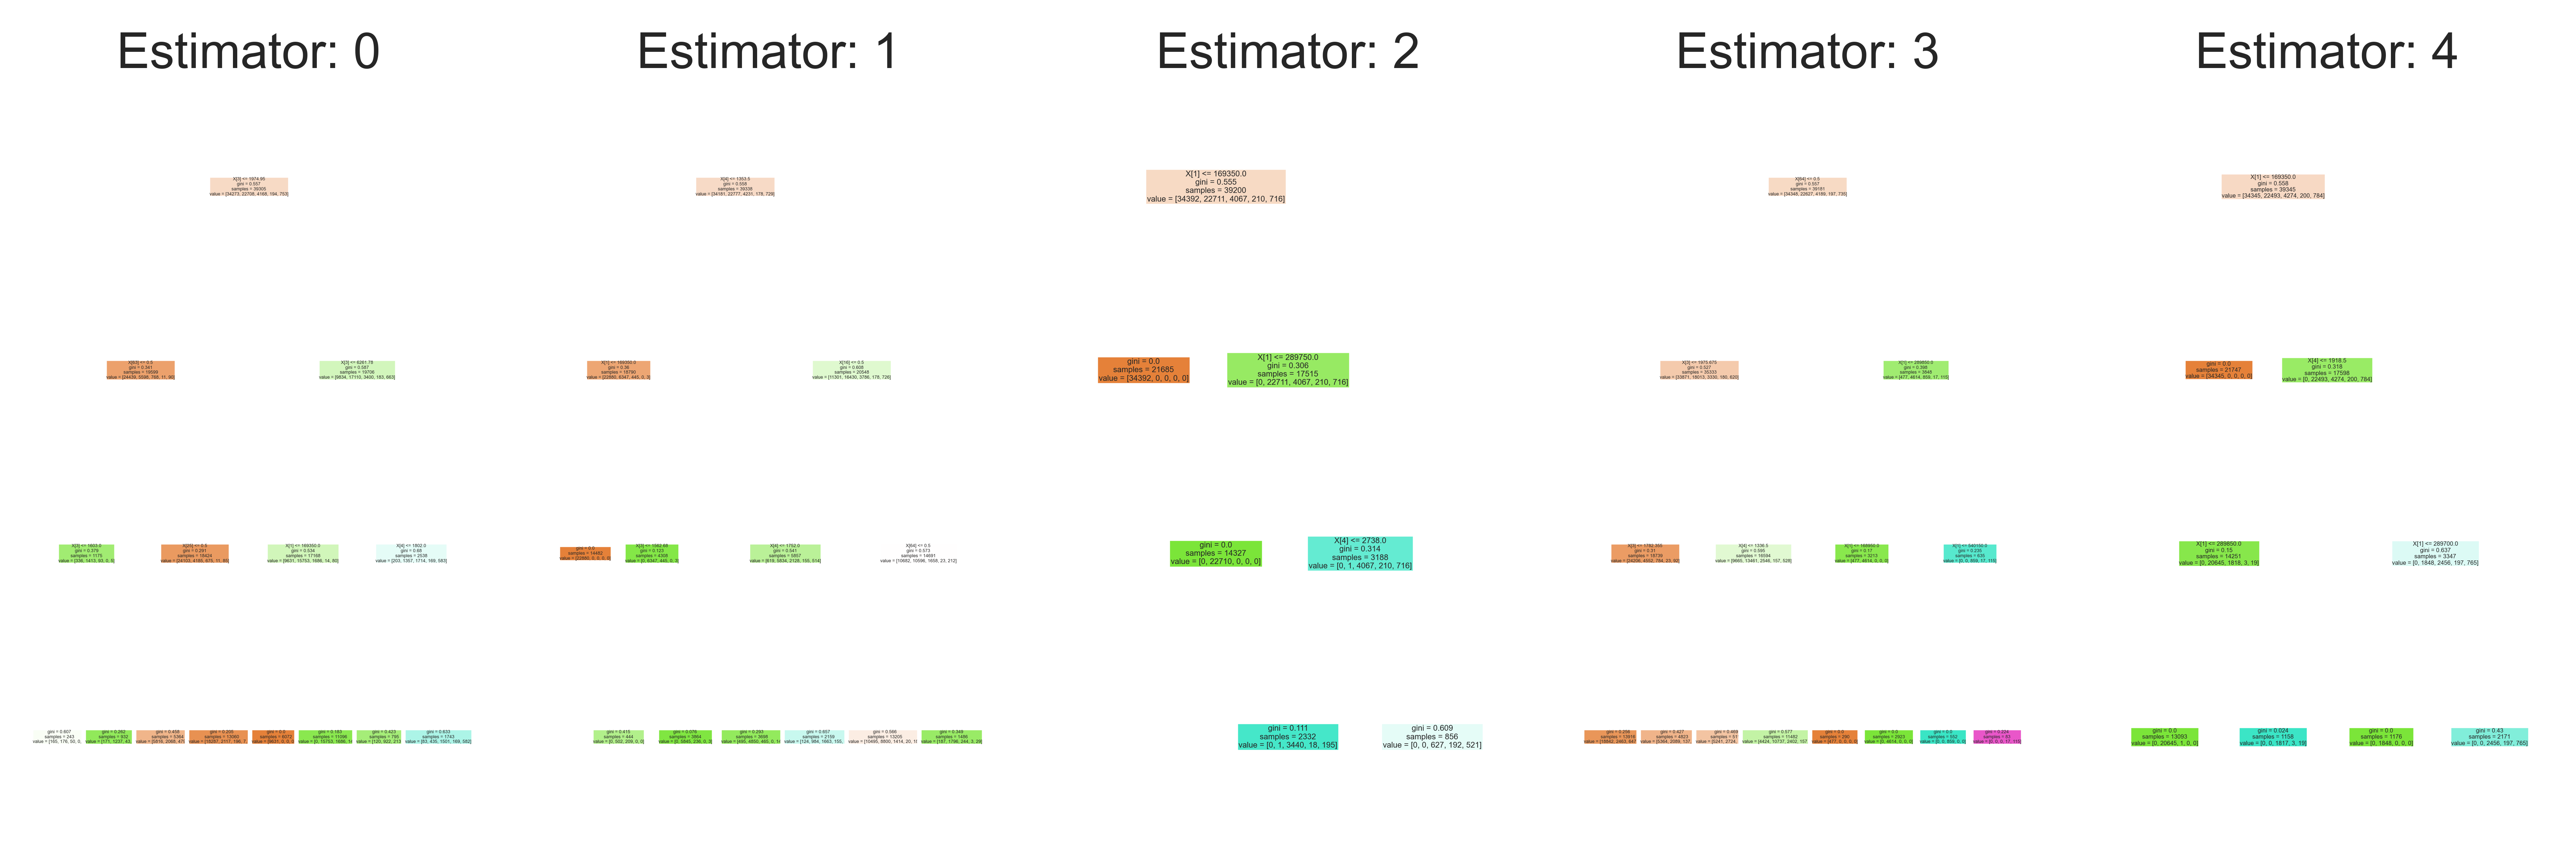

In [178]:
fig, axes = plt.subplots(nrows = 1 ,ncols = 5,figsize = (10,3), dpi=900)
for index in range(0, 5):
    tree.plot_tree(pipeRF_Tuning1[1].estimators_[index],
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')